Assessing current star galaxy performance by comparing with HST data in the COSMOS field.

In [1]:
import lsst.daf.persistence as dafPersist
import lsst.afw.display as afwDisplay
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import os
from astropy.table import Table, hstack, vstack
import numpy as np
from copy import deepcopy
import sys
sys.path.insert(0,'/home/sr525/Python_Code')
import match_lists


In [2]:
t_hst = Table.read("/home/nate2/shape_work/acs_clean_only.fits")
t_hsc = Table.read("/home/sr525/starGalaxy/HSC_COSMOS_clean.fits")
hsc_dir = "/datasets/hsc/repo/rerun/private/nate/shapeTest2/"
butler = dafPersist.Butler(inputs=hsc_dir)
t_info = Table.read("/home/sr525/starGalaxy/hscFeatures_class.fits")
t_test = Table.read("/home/sr525/starGalaxy/hscFeatures_test.fits")

In [3]:
def hst_hsc_im_comp(ras, decs, patches, t_hsc, t_hst, width):

    import make_cutout as mc
    import matplotlib.pyplot as plt
    import lsst.afw.coord as afwCoord
    import lsst.afw.geom as afwGeom
    from matplotlib.patches import Ellipse, PathPatch
    from astropy import wcs

    class_hsc = t_hsc["base_ClassificationExtendedness_value_I"]
    class_hst = t_hst["MU_CLASS"]
    
    for (j,(ra, dec, patch)) in enumerate(zip(ras, decs, patches)):
        print(j, ra, dec)
        print("MAG_AUTO", t_hst["MAG_AUTO"][j], "MU MAX", t_hst["MU_MAX"][j])
        print(t_hst["ELONGATION"][j])
        
        dataDetails = {"filter": "HSC-I", "tract": 9813, "patch": patch}
        exp = butler.get("deepCoadd_calexp", dataId=dataDetails)
        
        (_, vmin_hsc, vmax_hsc, im_hsc, ids_hsc, cs_hsc) = mc.make_cutout_lsst(ra, dec, \
                                                                      exp, width=width, \
                                                                      w_units="arcsecs")
    
        [(hdulist, vmin_hst, vmax_hst)] = mc.cutout_HST(ra, dec, width=width, \
                                                        return_data=True)
        [(hdulist1, vmin_hst1, vmax_hst1)] = mc.cutout_HST(ra, dec, width=4.0, \
                                                        return_data=True)
    
        im_hst = hdulist[1].data
        im_hst1 = hdulist1[1].data
    
        fig, ax_arr = plt.subplots(ncols=3, figsize=(8,3))
        ax_arr[0].imshow(im_hsc, vmin = vmin_hsc, vmax = vmax_hsc, cmap = "gray_r")
        ax_arr[1].imshow(im_hst, vmin = vmin_hst, vmax = vmax_hst, cmap = "gray_r")
        ax_arr[2].imshow(im_hst1, vmin = vmin_hst1*2, vmax = vmax_hst1*2, \
                         cmap = "gray_r")
   
        wcs_hsc = exp.getWcs()
        bbox_hsc = exp.getBBox()
        xoffset_hsc = bbox_hsc.getBeginX()
        yoffset_hsc = bbox_hsc.getBeginY()  
        
        w = wcs.WCS(hdulist[1].header, naxis = 2)
        w1 = wcs.WCS(hdulist1[1].header, naxis = 2)
        
        dists, inds = match_lists.match_lists([ra], [dec], t_hst["ALPHAPEAK_J2000"], \
                                             t_hst["DELTAPEAK_J2000"], \
                                             20.0/3600.0, numNei=200)
        #print dist, inds
        dists = dists[0]
        inds = inds[0]
        
        print("HST CLASS:", class_hst[inds[0]])

        for (ind, dist) in zip(inds, dists):
            if ind != len(t_hst):
                
                ra_plot = t_hst["ALPHAPEAK_J2000"][ind]
                dec_plot = t_hst["DELTAPEAK_J2000"][ind]
                
                k = t_hst["KRON_RADIUS"][ind]
                h_im = t_hst["A_IMAGE"][ind]
                w_im = t_hst["B_IMAGE"][ind]
                t_im = t_hst["THETA_IMAGE"][ind] 
                
                coord = afwCoord.Coord(afwGeom.Point2D(ra_plot, dec_plot), afwGeom.degrees)
                pix = wcs_hsc.skyToPixel(coord)
                x = pix[0]-xoffset_hsc-ids_hsc[1]+cs_hsc[2]
                y = pix[1]-yoffset_hsc-ids_hsc[3]+cs_hsc[0]
               
                circ_other = Ellipse(xy = (x,y), width=w_im, height=h_im, angle=t_im, \
                                     fill = False, color = "red", lw = 2)
                ax_arr[0].add_patch(circ_other)
                
                xy = w.wcs_world2pix(np.array([[ra_plot, dec_plot]], np.float_), 1)
                xy = (xy[0][0], xy[0][1])
                circ = Ellipse(xy = xy, width=w_im*k, height=h_im*k, angle=t_im, \
                               fill = False, color = "red", lw = 2)
                ax_arr[1].add_patch(circ)
                
                xy1 = w1.wcs_world2pix(np.array([[ra_plot, dec_plot]], np.float_), 1)
                xy1 = (xy1[0][0], xy1[0][1])
                circ1 = Ellipse(xy = xy1, width=w_im*k, height=h_im*k, angle=t_im, \
                               fill = False, color = "red", lw = 2)
                ax_arr[2].add_patch(circ1)
                
        
        dist, inds = match_lists.match_lists([ra], [dec], t_hsc["ra"], t_hsc["dec"], \
                                             100.0/3600.0, numNei=200)
        #print dist, inds
        dist = dist[0]
        inds = inds[0]
        
        print(t_hsc["base_PsfFlux_flag_edge_I"][inds[0]])
        print(t_hsc["base_PixelFlags_flag_edge_I"][inds[0]])
        print("HSC CLASS:", class_hsc[inds[0]])
        for ind in inds:
            if ind != len(t_hsc):
                
                ra_plot = t_hsc["ra"][ind]
                dec_plot = t_hsc["dec"][ind]
                coord = afwCoord.Coord(afwGeom.Point2D(ra_plot, dec_plot), afwGeom.degrees)
                pix = wcs_hsc.skyToPixel(coord)
                x = pix[0]-xoffset_hsc-ids_hsc[1]+cs_hsc[2]
                y = pix[1]-yoffset_hsc-ids_hsc[3]+cs_hsc[0]
                
                k = t_hsc["ext_photometryKron_KronFlux_psf_radius_I"][ind]
                xx = t_hsc["modelfit_CModel_region_final_ellipse_xx_I"][ind]
                yy = t_hsc["modelfit_CModel_region_final_ellipse_yy_I"][ind]
                xy = t_hsc["modelfit_CModel_region_final_ellipse_xy_I"][ind]
                mat = [[xx,xy],[xy,yy]]

                lam, v = np.linalg.eig(mat)
                lam = np.sqrt(lam)
                
                circ_other = Ellipse(xy = (x,y), width = lam[0], height = lam[1], \
                                     angle=np.arccos(v[0,0]), fill=False, color="blue", \
                                     lw = 1)
                ax_arr[0].add_patch(circ_other)
        
                xy = w.wcs_world2pix(np.array([[ra_plot, dec_plot]], np.float_), 1)
                xy = (xy[0][0], xy[0][1])
                circ = Ellipse(xy = xy, width=lam[0]*11.56, height=lam[1]*11.56, \
                               angle=np.arccos(v[0,0]), \
                               fill = False, color = "blue", lw = 1)
                ax_arr[1].add_patch(circ)
                
                xy1 = w1.wcs_world2pix(np.array([[ra_plot, dec_plot]], np.float_), 1)
                xy1 = (xy1[0][0], xy1[0][1])
                circ1 = Ellipse(xy = xy1, width=lam[0]*11.56, height=lam[1]*11.56, \
                                angle=np.arccos(v[0,0]), \
                                fill = False, color = "blue", lw = 1)
                ax_arr[2].add_patch(circ1)
                

        for ax in ax_arr:
            for i in iter(ax.spines.values()):
                i.set_linewidth(3.0)
        
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        
        if j == 0:
            ax_arr[0].set_title("HSC")
            ax_arr[1].set_title("HST")
            ax_arr[2].set_title("HST Zoom")
            title = "HSC and HST comparison"
            plt.suptitle(title)
        
        for i in iter(ax_arr[0].spines.values()):
            i.set_color("blue")
        for i in iter(ax_arr[1].spines.values()):
            i.set_color("red")
        plt.show()

In [4]:
def mad(xs, med):
    
    return np.median(np.fabs(xs-med))

In [5]:
from sklearn.preprocessing import PowerTransformer, minmax_scale

cols_to_use = ["G", "R", "I", "Z", "Y", "GR", "RI", "IZ", "ZY", "G_PM", "R_PM", "I_PM", \
               "Z_PM", "Y_PM", "M", "B"]
#cols_to_use = ["G", "R", "I", "Z", "Y", "G_PM", "R_PM", "I_PM", "Z_PM", "Y_PM", \
#               "M", "B"]
#cols_to_use = ["MAG", "G_PM", "R_PM", "I_PM", "Z_PM", "Y_PM"]
features = np.zeros((len(cols_to_use), len(t_info)))
scales = np.zeros((len(cols_to_use), 2))

for (i, col) in enumerate(cols_to_use):
    xs = t_info[col].data
    if np.min(xs) < 0:
        xs = xs + -1.0*np.min(xs) + 1
    pt = PowerTransformer(method='box-cox', standardize=True)
    xs_trans = pt.fit_transform(xs.reshape(-1,1))
    features[i] = xs_trans.reshape(1,-1)
    

In [6]:
from sklearn import svm
from sklearn.preprocessing import PowerTransformer, minmax_scale
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_gaussian_quantiles

input_class = t_info["CLASS"].data

clf  = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=600, \
                              learning_rate=1)


clf.fit(features.T, input_class)

print(clf)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=1, n_estimators=600, random_state=None)


In [7]:
from sklearn.calibration import CalibratedClassifierCV

clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(features.T, input_class, None)

probs_raw = clf.predict_proba(features.T)
predictions_raw = clf.predict(features.T)

In [8]:
from sklearn.preprocessing import PowerTransformer, minmax_scale

cols_to_use = ["G", "R", "I", "Z", "Y", "GR", "RI", "IZ", "ZY", "G_PM", "R_PM", "I_PM", \
               "Z_PM", "Y_PM", "M", "B"]
#cols_to_use = ["G", "R", "I", "Z", "Y", "G_PM", "R_PM", "I_PM", "Z_PM", "Y_PM", \
#               "M", "B"]
#cols_to_use = ["MAG", "G_PM", "R_PM", "I_PM", "Z_PM", "Y_PM"]
features = np.zeros((len(cols_to_use), len(t_test)))
scales = np.zeros((len(cols_to_use), 2))

for (i, col) in enumerate(cols_to_use):
    xs = t_test[col].data
    if np.min(xs) < 0:
        xs = xs + -1.0*np.min(xs) + 1
    pt = PowerTransformer(method='box-cox', standardize=True)
    xs_trans = pt.fit_transform(xs.reshape(-1,1))
    features[i] = xs_trans.reshape(1,-1)
    

In [9]:
probs = clf_isotonic.predict_proba(features.T)
predictions = clf_isotonic.predict(features.T)

In [10]:
def broken_axis_plot(xs, ys, thresh, xlabel, ylabel, vline=[], hline=[], col="b"):
    
    ids = np.where((ys > thresh))[0]
    ids2 = np.where((ys < thresh))[0]

    d = .015
    fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

    ax.plot(xs[ids], ys[ids], ".", color=col)
    
    ax.set_xlim(17, 29)
    ax.spines['bottom'].set_visible(False)
    ax.xaxis.tick_top()
    ax.tick_params(labeltop='off')
    ylims = ax.get_ylim()
    
    ax2.plot(xs[ids2], ys[ids2], ".", color=col)
    ax2.set_xlabel(xlabel)
    
    ax2.spines['top'].set_visible(False)
    ax2.xaxis.tick_bottom()
    ax2.set_ylim(-0.01, 0.05)
 
    axis_to_data = ax.transAxes + ax.transData.inverted()
    data_to_axis = axis_to_data.inverted()

    for x in vline:
        ax.axvline(x, ls=":", color="k")
        ax2.axvline(x, ls=":", color="k")
        x_ax = data_to_axis.transform((x,0))[0]
        kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
        ax.plot((-d+x_ax, +d+x_ax), (-d, +d), **kwargs)
        kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
        ax2.plot((-d+x_ax, +d+x_ax), (1 - d, 1 + d), **kwargs)
        
    for y in hline:
        if y > thresh:
            ax.axhline(y, ls=":", color="k")
        if y < thresh:
            ax2.axhline(y, ls=":", color="k") 
    
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
    ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal  

    
    ax2.text(-0.15, 2.1, ylabel, transform=ax2.transAxes, rotation=90)
    plt.show()

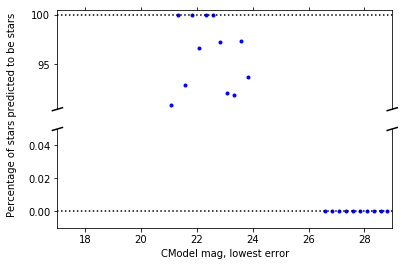

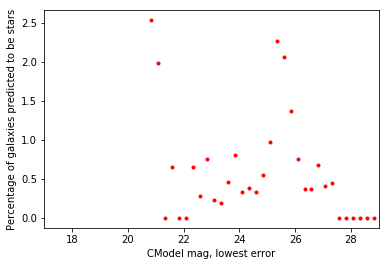

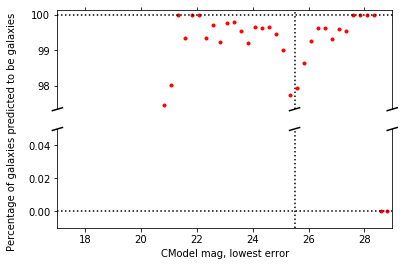

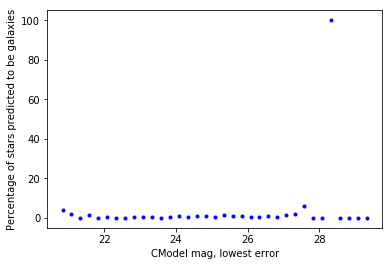

In [11]:
import matplotlib.pyplot as plt

xs = t_test["MAG"]
ys = []

sep_prob = 0.2

xs = np.arange(np.min(t_test["MAG"])+4.0, np.max(t_test["MAG"]), 0.25)
for (i, mag) in enumerate(xs[1:]):
    ids = np.where((t_test["CLASS"] == 0) & (probs[:,0] > sep_prob) & \
                   (t_test["MAG"] < mag) & (t_test["MAG"] > xs[i]))[0]
    num = np.where((t_test["MAG"] < mag) & (t_test["CLASS"] == 0) & \
                   (t_test["MAG"] > xs[i]))[0]
    try:
        ys.append(len(ids)/len(num)*100)
    except ZeroDivisionError:
        ys.append(0)

ys = np.array(ys)
xlabel = "CModel mag, lowest error"
ylabel = "Percentage of stars predicted to be stars"
broken_axis_plot(xs[1:], ys, 90, xlabel, ylabel, hline=[0, 100])

ys = []
xs = np.arange(np.min(t_test["MAG"])+4.0, np.max(t_test["MAG"]), 0.25)
for (i, mag) in enumerate(xs[1:]):
    ids = np.where((t_test["CLASS"] == 1) & (probs[:,0] > sep_prob) & \
                   (t_test["MAG"] < mag) & (t_test["MAG"] > xs[i]))[0]
    num = np.where((t_test["MAG"] < mag) & (t_test["CLASS"] == 1) & \
                   (t_test["MAG"] > xs[i]))[0]
    try:
        ys.append(len(ids)/len(num)*100)
    except ZeroDivisionError:
        ys.append(0)
    
plt.plot(xs[1:], ys, "r.")
plt.ylabel("Percentage of galaxies predicted to be stars")
plt.xlabel("CModel mag, lowest error")
plt.xlim(17, 29)
plt.show()

ys = []
xs = np.arange(np.min(t_test["MAG"])+4.0, np.max(t_test["MAG"]), 0.25)
for (i, mag) in enumerate(xs[1:]):
    ids = np.where((t_test["CLASS"] == 1) & (probs[:,0] < sep_prob) & \
                   (t_test["MAG"] < mag) & (t_test["MAG"] > xs[i]))[0]
    num = np.where((t_test["MAG"] < mag) & (t_test["CLASS"] == 1) & \
                   (t_test["MAG"] > xs[i]))[0]
    try:
        ys.append(len(ids)/len(num)*100)
    except ZeroDivisionError:
        ys.append(0)

ys = np.array(ys)
xlabel = "CModel mag, lowest error"
ylabel = "Percentage of galaxies predicted to be galaxies"
broken_axis_plot(xs[1:], ys, 90, xlabel, ylabel, hline=[0, 100], vline=[25.5], col="r")
        
ys = []
xs = np.arange(np.min(t_test["MAG"])+4.0, np.max(t_test["MAG"]), 0.25)
for (i, mag) in enumerate(xs[1:]):
    ids = np.where((t_test["CLASS"] == 0) & (probs[:,0] < sep_prob) & \
                   (t_test["MAG"] < mag) & (t_test["MAG"] > xs[i]))[0]
    num = np.where((t_test["MAG"] < mag) & (t_test["CLASS"] == 1) & \
                   (t_test["MAG"] > xs[i]))[0]
    try:
        ys.append(len(ids)/len(num)*100)
    except ZeroDivisionError:
        ys.append(0)

plt.plot(xs[1:], ys, "b.")
plt.ylabel("Percentage of stars predicted to be galaxies")
plt.xlabel("CModel mag, lowest error")
plt.show()

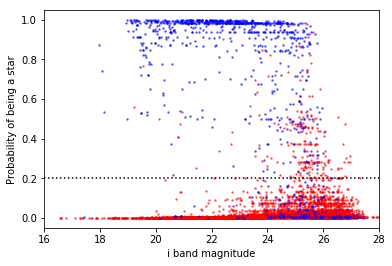

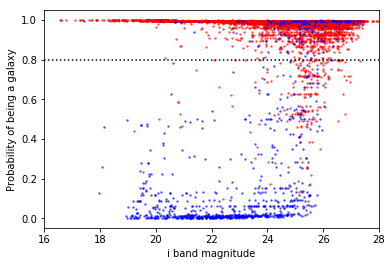

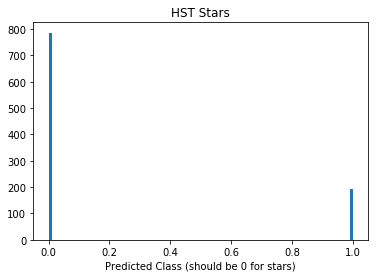

194


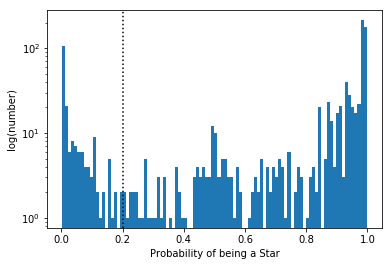

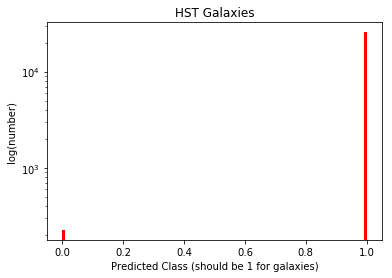

226


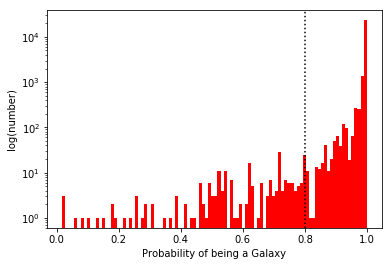

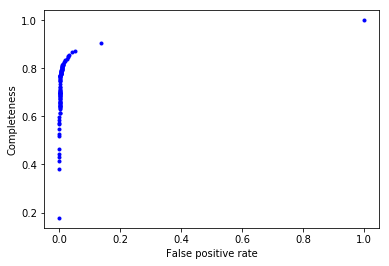

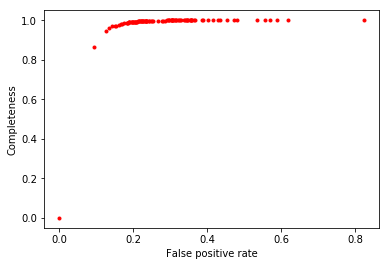

In [12]:
star = np.where((t_test["CLASS"] == 0))[0]
gal = np.where((t_test["CLASS"] == 1))[0]

predictions = np.zeros(len(t_test))
predictions[probs[:,0] < sep_prob] = 1.0

plt.plot(t_test["MAG"][gal], probs[:,0][gal], "r.", ms=3, alpha=0.5)
plt.plot(t_test["MAG"][star], probs[:,0][star], "b.", ms=3, alpha=0.5)
plt.xlim(16.0, 28.0)
plt.axhline(sep_prob, color="k", ls=":")
plt.xlabel("i band magnitude")
plt.ylabel("Probability of being a star")
plt.show()

plt.plot(t_test["MAG"][gal], probs[:,1][gal], "r.", ms=3, alpha=0.5)
plt.plot(t_test["MAG"][star], probs[:,1][star], "b.", ms=3, alpha=0.5)
plt.xlim(16.0, 28.0)
plt.xlabel("i band magnitude")
plt.axhline(1-sep_prob, color="k", ls=":")
plt.ylabel("Probability of being a galaxy")
plt.show()
plt.hist(predictions[star], bins=100)
plt.title("HST Stars")
plt.xlabel("Predicted Class (should be 0 for stars)")
plt.show()

print(len(np.where((predictions[star] == 1))[0]))

plt.hist(probs[:,0][star], bins=100)
plt.axvline(sep_prob, color="k", ls=":")
plt.xlabel("Probability of being a Star")
plt.yscale("log")
plt.ylabel("log(number)")
plt.show()

plt.hist(predictions[gal], bins=100, color="r")
plt.title("HST Galaxies")
plt.xlabel("Predicted Class (should be 1 for galaxies)")
plt.yscale("log")
plt.ylabel("log(number)")
plt.show()

print(len(np.where((predictions[gal] == 0))[0]))

plt.hist(probs[:,1][gal], bins=100, color="r")
plt.xlabel("Probability of being a Galaxy")
plt.yscale("log")
plt.ylabel("log(number)")
plt.axvline(1-sep_prob, color="k", ls=":")
plt.show()

xs = []
ys = []
for thresh in np.arange(0.0, 1.0, 0.01):
    false_positive = np.where((t_test["CLASS"] == 1) & (probs[:,0] > thresh))[0]
    true_positive = np.where((t_test["CLASS"] == 0) & (probs[:,0] > thresh))[0]
    false_negatives = np.where((t_test["CLASS"] == 0) & (probs[:,1] > (1-thresh)))[0]
    true_negative = np.where((t_test["CLASS"] == 1) & (probs[:,1] > (1-thresh)))[0]
    
    try:
        xs.append(len(false_positive)/(len(false_positive) + len(true_negative)))
    except ZeroDivisionError:
        xs.append(0.0)
    try:
        ys.append(len(true_positive)/(len(false_negatives) + len(true_positive)))
    except ZeroDivisionError:
        ys.append(0.0)

plt.plot(xs, ys, "b.")
plt.xlabel("False positive rate")
plt.ylabel("Completeness")
plt.show()

xs = []
ys = []
for thresh in np.arange(0.0, 1.0, 0.01):
    false_positive = np.where((t_test["CLASS"] == 0) & (probs[:,0] < thresh))[0]
    true_positive = np.where((t_test["CLASS"] == 1) & (probs[:,0] < thresh))[0]
    false_negatives = np.where((t_test["CLASS"] == 1) & (probs[:,0] > (thresh)))[0]
    true_negative = np.where((t_test["CLASS"] == 0) & (probs[:,0] > (thresh)))[0]
    
    try:
        xs.append(len(false_positive)/(len(false_positive) + len(true_negative)))
    except ZeroDivisionError:
        xs.append(0.0)
    try:
        ys.append(len(true_positive)/(len(false_negatives) + len(true_positive)))
    except ZeroDivisionError:
        ys.append(0.0)

plt.plot(xs, ys, "r.")
plt.xlabel("False positive rate")
plt.ylabel("Completeness")
plt.show()

HST stars classified incorrectly: 194 out of 980
HST galaxies classified incorrectly: 226 out of 25956


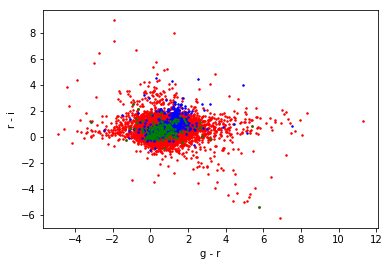

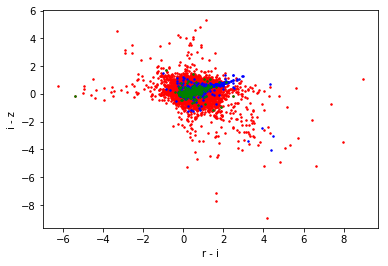

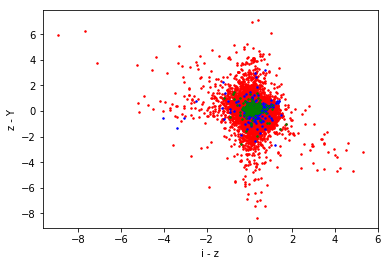

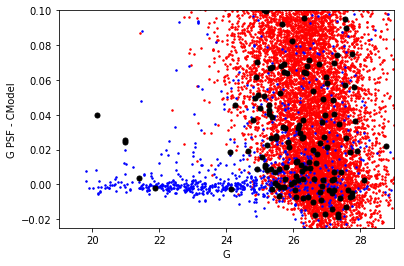

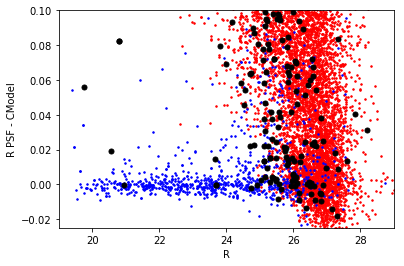

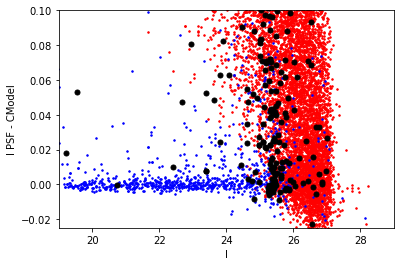

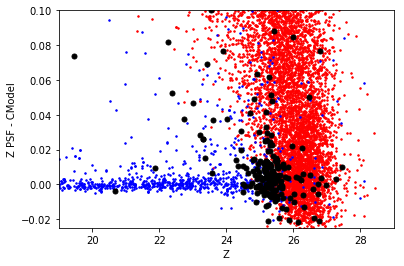

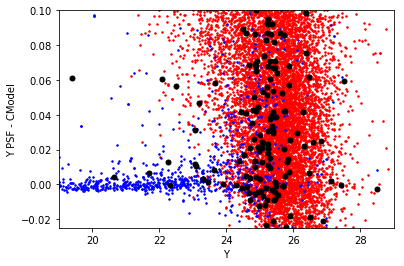

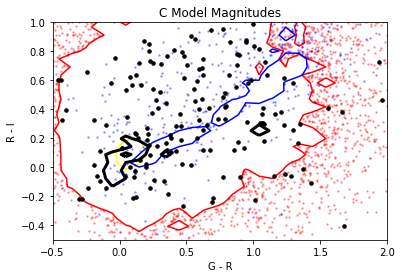

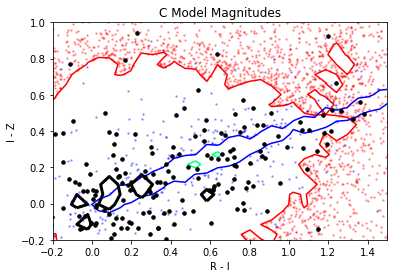

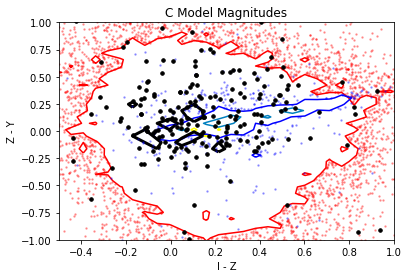

In [13]:
wrong_stars = np.where((probs[:,0] < sep_prob) & (t_test["CLASS"] == 0))[0]
print("HST stars classified incorrectly:", len(wrong_stars), "out of", len(star))

wrong_gals = np.where((probs[:,0] > (sep_prob)) & (t_test["CLASS"] == 1))[0]
print("HST galaxies classified incorrectly:", len(wrong_gals), "out of", len(gal))

#for col in t_test.columns[2:]:
#    plt.hist(t_test[col][gal], bins = 1000, color="r")
#    plt.hist(t_test[col][star], bins = 1000, color="b")
#    plt.hist(t_test[col][wrong_stars], bins = 1000, color="g")
#    plt.xlabel(col)
#    plt.show()

plt.plot(t_test["GR"][gal], t_test["RI"][gal], "r.", ms=3)
plt.plot(t_test["GR"][star], t_test["RI"][star], "b.", ms=3)
plt.plot(t_test["GR"][wrong_gals], t_test["RI"][wrong_gals], "g.", ms=3)
plt.xlabel("g - r")
plt.ylabel("r - i")
plt.show()

plt.plot(t_test["RI"][gal], t_test["IZ"][gal], "r.", ms=3)
plt.plot(t_test["RI"][star], t_test["IZ"][star], "b.", ms=3)
plt.plot(t_test["RI"][wrong_gals], t_test["IZ"][wrong_gals], "g.", ms=3)
plt.xlabel("r - i")
plt.ylabel("i - z")
plt.show()

plt.plot(t_test["IZ"][gal], t_test["ZY"][gal], "r.", ms=3)
plt.plot(t_test["IZ"][star], t_test["ZY"][star], "b.", ms=3)
plt.plot(t_test["IZ"][wrong_gals], t_test["ZY"][wrong_gals], "g.", ms=3)
plt.xlabel("i - z")
plt.ylabel("z - Y")
plt.show()

for band in ["G", "R", "I", "Z", "Y"]:
    plt.plot(t_test[band][gal], t_test[band + "_PM"][gal], "r.", ms=3)
    plt.plot(t_test[band][star], t_test[band + "_PM"][star], "b.", ms=3)
    plt.plot(t_test[band][wrong_gals], t_test[band + "_PM"][wrong_gals], "k.", ms=10)
    plt.ylim(-0.025, 0.1)
    plt.xlim(19, 29)
    plt.xlabel(band)
    plt.ylabel(band + " PSF - CModel")
    plt.show()

    
magCol = "magPsf_"
magModCol = "magModel_"
magPsfCol = "magPsf_"

xlims = [(-0.5,2), (-0.2,1.5), (-0.5,1.0)]
ylims = [(-0.5,1), (-0.2,1.0), (-1.0,1.0)]

i = 0
bands = ["GR", "RI", "IZ", "ZY"]
while i < len(bands)-1:
    
    xs_s = t_test[bands[i]][star]
    ys_s = t_test[bands[i+1]][star]
    xs_e = t_test[bands[i]][gal]
    ys_e = t_test[bands[i+1]][gal]
    xs_w = t_test[bands[i]][wrong_gals]
    ys_w = t_test[bands[i+1]][wrong_gals]
   
    counts_s, xbins_s, ybins_s, im = plt.hist2d(xs_s, ys_s, bins=100)
    counts_e, xbins_e, ybins_e, im = plt.hist2d(xs_e, ys_e, bins=(xbins_s, ybins_s))
    counts_w, xbins_w, ybins_w, im = plt.hist2d(xs_w, ys_w, bins=(xbins_s, ybins_s))
    plt.close()
    levels = np.arange(np.min(counts_e[counts_e > 0])*10, np.max(counts_e), 200)
    x = xbins_e[:-1]
    y = ybins_e[:-1]
    z = counts_e.T
    levels_e = plt.contour(x, y, z, cmap=plt.cm.autumn, levels=levels)
    paths_e = levels_e.collections[0].get_paths()
    inside = paths_e[0].contains_points(np.array([xs_e, ys_e]).T)
    for path_e in paths_e[1:]:
        inside_new = path_e.contains_points(np.array([xs_e, ys_e]).T)
        inside = inside | inside_new
    plt.plot(xs_e[~inside], ys_e[~inside], "r.", ms=3, alpha=0.3, mfc="r", zorder=-1)
        
    levels = np.arange(np.min(counts_s[counts_s > 0])*5, np.max(counts_s), 20)
    x = xbins_s[:-1]
    y = ybins_s[:-1]
    z = counts_s.T
    levels_s = plt.contour(x, y, z, cmap=plt.cm.winter, levels = levels)
    paths_s = levels_s.collections[0].get_paths()
    inside = paths_s[0].contains_points(np.array([xs_s, ys_s]).T)
    for path_s in paths_s[1:]:
        inside_new = path_s.contains_points(np.array([xs_s, ys_s]).T)
        inside = inside | inside_new
    plt.plot(xs_s[~inside], ys_s[~inside], "b.", ms=3, alpha=0.3)
    
    levels = np.arange(np.min(counts_w[counts_w > 0])*2, np.max(counts_w), 5)
    x = xbins_w[:-1]
    y = ybins_w[:-1]
    z = counts_w.T
    levels_w = plt.contour(x, y, z, colors="k", levels=levels, linewidths=3)
    paths_w = levels_w.collections[0].get_paths()
    inside = paths_w[0].contains_points(np.array([xs_w, ys_w]).T)
    for path_w in paths_w[1:]:
        inside_new = path_w.contains_points(np.array([xs_w, ys_w]).T)
        inside = inside | inside_new
    plt.plot(xs_w[~inside], ys_w[~inside], "k.", ms=7)
    
    
    plt.title("C Model Magnitudes")
    plt.xlim(xlims[i])
    plt.ylim(ylims[i])
    plt.xlabel(bands[i][0] + " - " + bands[i][1])
    plt.ylabel(bands[i+1][0] + " - " + bands[i+1][1])
    plt.show()

    i += 1

7
0 150.32862265 2.24085213475
MAG_AUTO 24.4383 MU MAX 22.3293
2.49363
/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_064_sci.fits

/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_064_sci.fits

HST CLASS: 1
False
False
HSC CLASS: 1.0


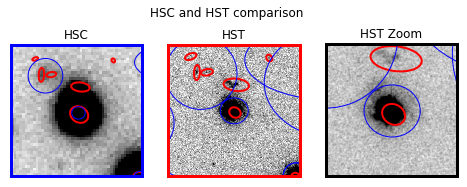

1 150.244599114 2.43227250293
MAG_AUTO 23.8577 MU MAX 21.197
1.15097
/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_076_sci.fits

/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_076_sci.fits

HST CLASS: 1
False
False
HSC CLASS: 1.0


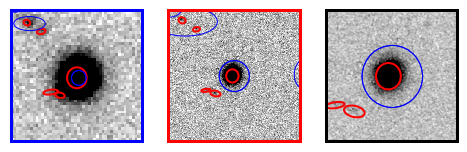

2 150.187948357 2.35291685812
MAG_AUTO 23.7051 MU MAX 20.5083
1.10171
/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_077_sci.fits

/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_077_sci.fits

HST CLASS: 1
False
False
HSC CLASS: 1.0


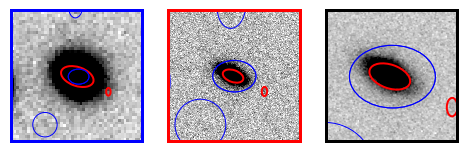

3 150.244599114 2.43227250293
MAG_AUTO 24.5589 MU MAX 21.2861
1.27748
/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_076_sci.fits

/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_076_sci.fits

HST CLASS: 1
False
False
HSC CLASS: 1.0


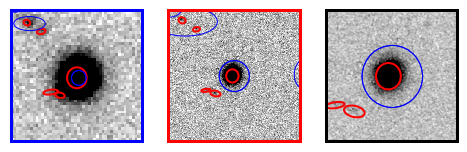

4 150.106194783 2.33377589972
MAG_AUTO 20.903 MU MAX 16.4351
1.02563
/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_077_sci.fits

/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_077_sci.fits

HST CLASS: 1
False
False
HSC CLASS: 1.0


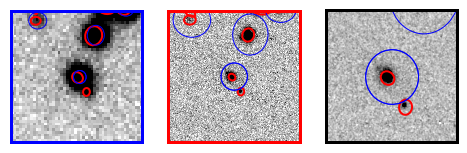

5 149.967610017 2.49988301383
MAG_AUTO 23.3483 MU MAX 21.8942
3.64645
/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_090_sci.fits

/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_090_sci.fits

HST CLASS: 1
False
False
HSC CLASS: 0.0


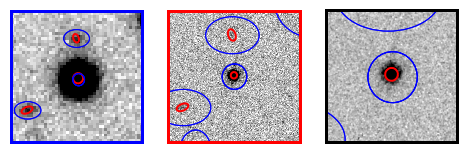

6 149.839612132 2.33986545187
MAG_AUTO 23.7457 MU MAX 21.8052
1.86408
/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_079_sci.fits

/scratch/sr525/hstCosmosImages/tiles/acs_I_030mas_079_sci.fits

HST CLASS: 1
False
False
HSC CLASS: 1.0


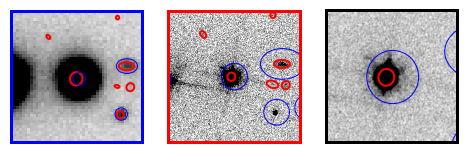

In [14]:
sg = "base_ClassificationExtendedness_value_I"


#print(t_hsc.columns)
#sg_sep = t_hsc_match[magPsfCol+"G"][star] - t_hsc_match[magModCol+"G"][star]
sg_ids = np.where((probs[:,0] > sep_prob) & (t_test["CLASS"] == 1) & \
                  (t_test["G"] < 22))[0]

print(len(sg_ids))

ras = t_test["RA"][sg_ids]
decs = t_test["DEC"][sg_ids]
patches = t_test["PATCH"][sg_ids]

hst_hsc_im_comp(ras, decs, patches, t_hsc, t_hst, 8.0)